<a href="https://colab.research.google.com/github/root-epifit/HPC_Sber_2025/blob/main/%D0%94%D0%B73_in_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 * Скачать и приготовить датасет Московского или
 Лондонского метро для решения стандартной задачи
 Pagerank. Вывести топ-5 станций подземки по такому
 ранжированию. (50 %)

 * Применить метод Simrank к графу Московской подземки
 (30 %)

 * Сгенерировать случайные разреженные графы и сравнить
 производительность реализаций Pagerank с CSR-форматом
 и без него. (20 %

## Подготовка датасетa

In [2]:
! pip install -q kaggle

In [3]:
import kagglehub
from google.colab import files

import pandas as pd
import networkx as nx
import math

### Загрузка датасета

In [4]:
# загружаю свой kaggle-токен (нужен чтобы стянуть датасет)
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# проверка, что API работает
#! kaggle datasets list

# Загружаем датасет Moscow Metro
# Download latest version
path = kagglehub.dataset_download("samoilovmikhail/moscow-metro-stations")
print("Path to dataset files:", path)

!cp $path/* .
!ls -la *.csv

Saving kaggle.json to kaggle.json


100%|██████████| 12.2k/12.2k [00:00<00:00, 14.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/samoilovmikhail/moscow-metro-stations/versions/8


-rw-r--r-- 1 root root  1449 Aug 21 19:52 metro_lines.csv
-rw-r--r-- 1 root root 34560 Aug 21 19:52 metro_stations.csv


### Изучение датасета

In [6]:
ms = pd.read_csv("./metro_stations.csv")
ml = pd.read_csv("./metro_lines.csv")

In [35]:
ml.head(2)

,Line,English_name,Russian_name,Stations,Color,First_Opened,Latest_extension,Length,Avg_Dist
0,1,Sokolnicheskaya,Сокольническая,27,#EF161E,1935,2024,43.4,1.61
1,2,Zamoskvoretskaya,Замоскворецкая,24,#2DBE2C,1938,2018,42.8,1.86


In [32]:
ms[(ms['Line']==1) & (ms['Station_index']==6)].head(10)

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
5,6,Komsomolskaya,1,Комсомольская,-8.0,5 7,93,1935-05-15,55.7753,37.6561,column triple-span


In [33]:
ms[ms['Station_index']==93].head(10)

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
92,93,Komsomolskaya,5,Комсомольская,-37.0,92 94,6,1952-01-30,55.7748,37.6549,column triple-vault


In [34]:
ms[ms['Station_index']==92].head(10)

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
91,92,Kurskaya,5,Курская,-40.0,91 93,206 66,1950-01-01,55.757,37.6595,column triple-vault


In [38]:
# Итого:

# ml.Line - код линии
# ml.Russian_name - название линии

# ms.Line - код линии -> ml.Line
# ms.Russian_name - название станции
# ms.Station_index - код станции
# ms.Line_Neighbours - коды предыдущей и следующей станции (на линии)
# ms.Transfers - коды станций, на которые есть пересадки с данной станции

## Подготовка графа

In [37]:
G = nx.Graph()

stations = []
edges = []
idx2name = {}

df = ms[['Station_index', 'Russian_name', 'Line', 'Line_Neighbors', 'Transfers']]

for idx, row in df.iterrows():
    station = row['Station_index']
    name    = row['Russian_name'].lstrip().rstrip()
    line    = row['Line']
    idx2name[station]=name
    edge = [(station, int(e)) for e in row['Line_Neighbors'].replace("\xa0",",").replace(" ",",").split(",")]
    # str(...) для преобразования NaN (имеет тип float) в 'nan'
    transfer = [(station,int(e)) if e != 'nan' else (0,0) for e in str(row['Transfers']).replace("\xa0",",").replace(" ",",").split(",")]

    stations.append((station, {"line":line}) )
    edges = edges + edge + transfer

# убираем мусорные (0,0)
edges = [e for e in filter(lambda x: x != (0,0), edges)]

# заменяем коды станций на названия + код
stations = [(idx2name[i]+','+str(i), o) for (i,o) in stations]
edges    = [(idx2name[l]+','+str(l), idx2name[r]+','+str(r)) for (l,r) in edges]

G.add_nodes_from(stations)
G.add_edges_from(edges)


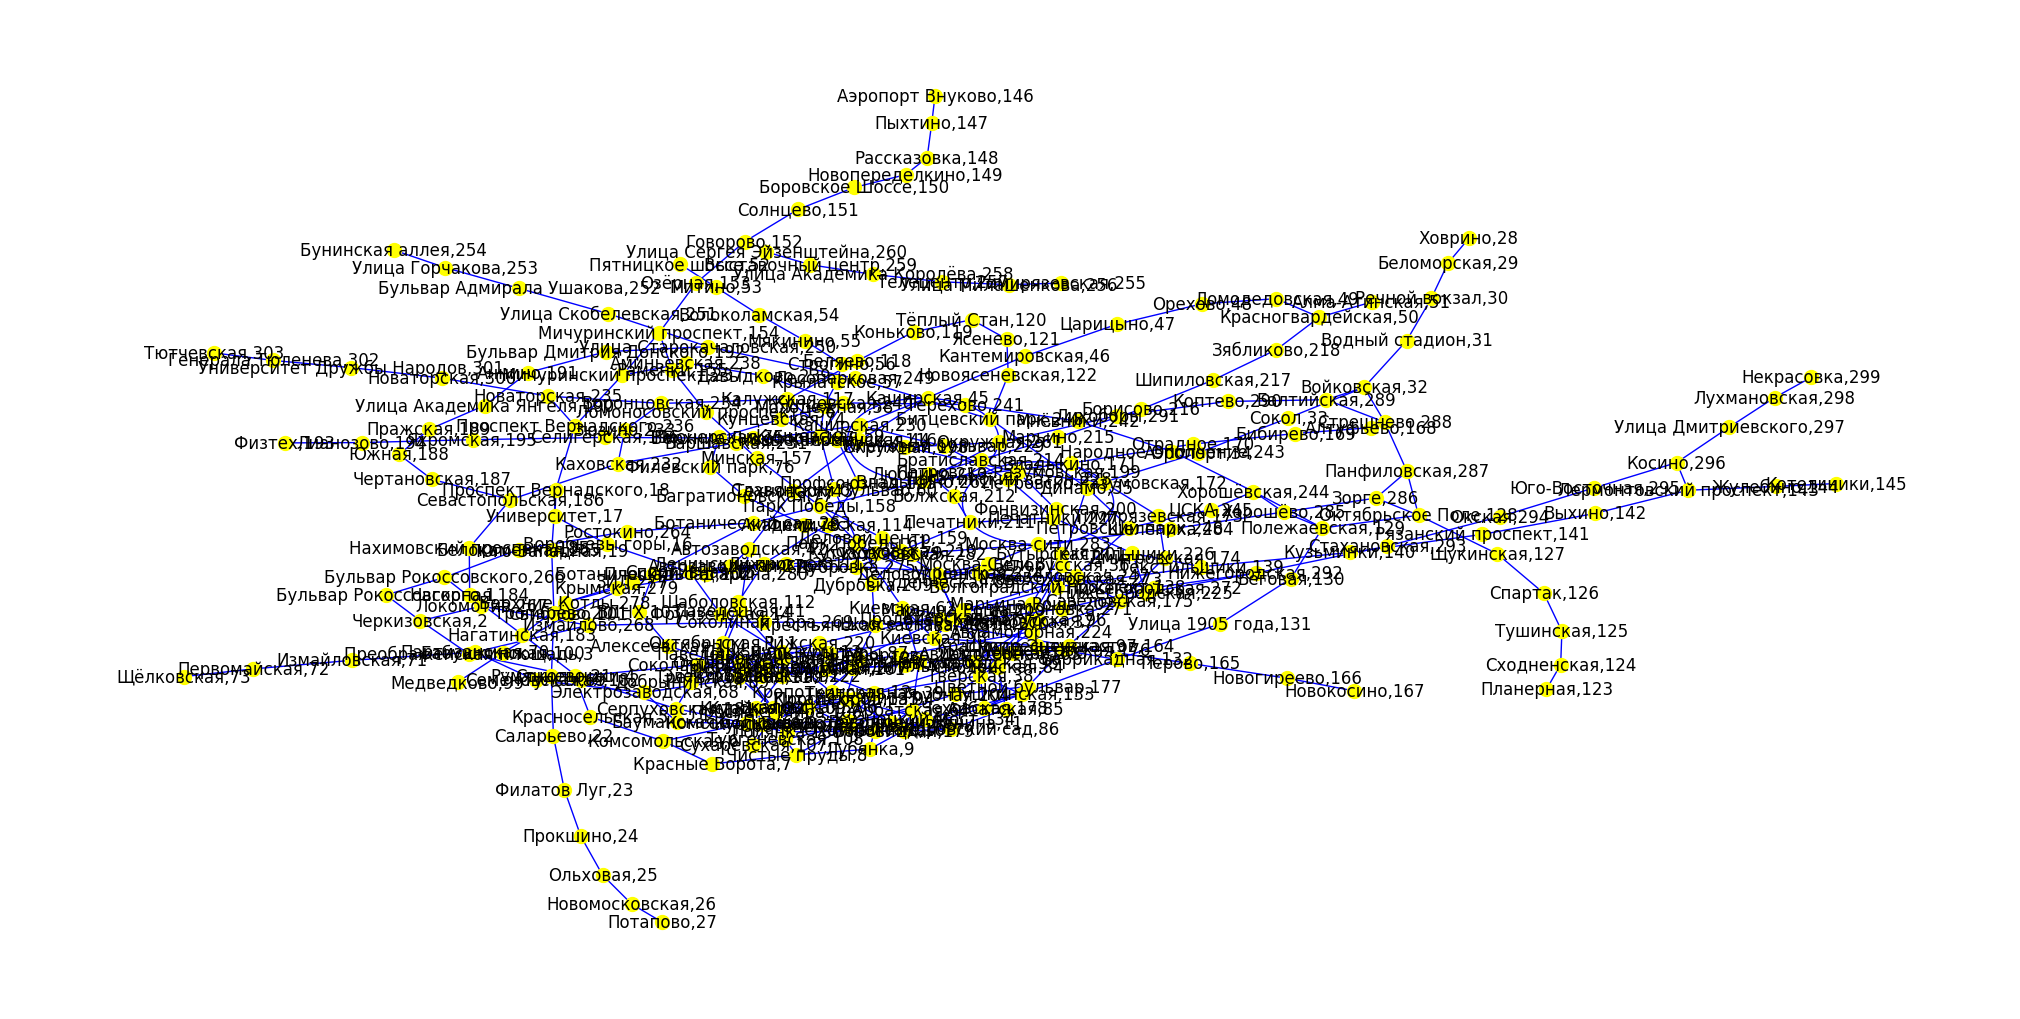

In [66]:
import matplotlib.pyplot as plt

options = {
    'node_size': 100,
    'node_color':'yellow',
    'edge_color':'blue',
    'width':1,
    'font_weight':'normal'
}

fig = plt.figure(1, figsize=(20,10))
#pos = nx.circular_layout(G)
#pos = nx.random_layout(G)
#nx.draw(G, pos, with_labels=True, **options)
nx.draw(G, with_labels=True, **options)
#nx.draw_spring(G, with_labels=True, **options)

## Top5 станций

In [57]:
station_rank = nx.pagerank(G)
sorted(station_rank.items(), key=lambda item: item[1], reverse=True)[:5]

[('Киевская,83', 0.0051495161451000655),
 ('Войковская,32', 0.0049235582229606644),
 ('Кунцевская,240', 0.004908265474521621),
 ('Кунцевская,59', 0.00489002698597442),
 ('Красногвардейская,50', 0.004824977720234007)]

In [64]:
# смотрим в датасете
ms[ms['Station_index'].isin([83,32,240,59,50])]

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
31,32,Voykovskaya,2,Войковская,-7.0,31 33,288 289,1964-12-31,55.8190,37.4980,column triple-span
49,50,Krasnogvardeyskaya,2,Красногвардейская,-9.0,49 51,218,1985-09-07,55.6137,37.7444,single-vault shallow
58,59,Kuntsevskaya,3,Кунцевская,0.0,58 60,74 240,2008-01-07,55.7307,37.4459,surface open
82,83,Kiyevskaya,4,Киевская,-8.7,82 80 84,62 98,1937-03-20,55.7436,37.5655,column triple-vault
239,240,Kuntsevskaya,11,Кунцевская,-31.0,239 241,59 74,2021-12-07,55.7304,37.4457,column triple-span


В-общем, результат похож на правду:

* Киевская - с ней понятно - пересечение 3-х линий метро
* Войковская - переход на 2 станции (Стрешнево и Балтийская)
* Кунцевская - пересечение 3-х линий + переход на ст.Кунцевская МЦД
* Красногвардейская - пересечение 2-х линий

Источник: https://mosmetro.ru/metro-map

In [112]:
edges = [(0,0)]
station = 2
edges + ([(station, e) for e in df[[df.Station_index == 3]].Transfers.replace("\xa0",",").replace(" ",",").split(",")])


KeyError: "None of [Index([(False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...)], dtype='object')] are in the [columns]"

,Line,English_name,Russian_name,Stations,Color,First_Opened,Latest_extension,Length,Avg_Dist
0,1,Sokolnicheskaya,Сокольническая,27,#EF161E,1935,2024,43.4,1.61
1,2,Zamoskvoretskaya,Замоскворецкая,24,#2DBE2C,1938,2018,42.8,1.86
2,3,Arbatsko-Pokrovskaya,Арбатско-Покровская,22,#0078BE,1938,2012,45.1,2.15


In [25]:

 ms[['Station_index', 'Russian_name', 'Line_Neighbors', 'Transfers']].head(3)
 ml[['Line', 'Russian_name', 'Stations']].head(3)

,Line,Russian_name,Stations
0,1,Сокольническая,27
1,2,Замоскворецкая,24
2,3,Арбатско-Покровская,22


In [21]:
ml

,Line,English_name,Russian_name,Stations,Color,First_Opened,Latest_extension,Length,Avg_Dist
0,1,Sokolnicheskaya,Сокольническая,27,#EF161E,1935,2024,43.4,1.61
1,2,Zamoskvoretskaya,Замоскворецкая,24,#2DBE2C,1938,2018,42.8,1.86
2,3,Arbatsko-Pokrovskaya,Арбатско-Покровская,22,#0078BE,1938,2012,45.1,2.15
3,4,Filyovskaya,Филёвская,13,#00BFFF,1958,2006,14.9,1.24
4,5,Koltsevaya,Кольцевая,12,#8D5B2D,1950,1954,19.3,1.61
5,6,Kaluzhsko-Rizhskaya,Калужско-Рижская,24,#ED9121,1958,1990,37.8,1.63
6,7,Tagansko-Krasnopresnenskaya,Таганско-Краснопресненская,23,#800080,1966,2015,42.2,1.92
7,8,Kalininskaya-Solntsevskaya,Калининская-Солнцевская,22,#FFD702,1979,2023,44.6,2.15
8,9,Serpukhovsko-Timiryazevskaya,Серпуховско-Тимирязевская,25,#999999,1985,2002,41.5,1.72
9,10,Lyublinsko-Dmitrovskaya,Люблинско-Дмитровская,26,#99CC00,1995,2023,44.3,1.77


In [18]:
ms

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
0,1,Bulvar Rokossovskogo,1,Бульвар Рокоссовского,-8.0,2,266,1990-08-01,55.8147,37.7342,column triple-span
1,2,Cherkizovskaya,1,Черкизовская,-9.0,1 3,267,1990-08-01,55.8039,37.7447,single-vault shallow
2,3,Preobrazhenskaya Ploshchad,1,Преображенская площадь,-8.0,2 4,NaN,1965-12-31,55.7964,37.7150,column triple-span
3,4,Sokolniki,1,Сокольники,-9.0,3 5,221,1935-05-15,55.7889,37.6803,single-vault shallow
4,5,Krasnoselskaya,1,Красносельская,-8.0,4 6,NaN,1935-05-15,55.7799,37.6673,column double-span
...,...,...,...,...,...,...,...,...,...,...,...
298,299,Nekrasovka,15,Некрасовка,-16.0,298,NaN,2019-06-03,55.7036,37.9264,column double-span
299,300,Novatorskaya,16,Новаторская,-11.0,301,235,2024-09-07,55.6690,37.5238,column triple-span
300,301,Universitet Druzhby Narodov,16,Университет Дружбы Народов,-23.0,300 302,NaN,2024-09-07,55.6484,37.5076,column triple-span
301,302,Generala Tyuleneva,16,Генерала Тюленева,-20.0,301 303,NaN,2024-09-07,55.6262,37.4860,column triple-span


Path to dataset files: /kaggle/input/moscow-metro-stations
-rw-r--r-- 1 root root  1449 Aug 21 10:54 metro_lines.csv
-rw-r--r-- 1 root root 34560 Aug 21 10:54 metro_stations.csv


In [5]:
! kaggle competitions download -c 'moscow_metro'

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/moscow_metro


In [8]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = ""

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "samoilovmikhail/moscow-metro-stations",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-2922614650.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ValueError: Unsupported file extension: ''. Supported file extensions are: .csv, .tsv, .json, .jsonl, .xml, .parquet, .feather, .sqlite, .sqlite3, .db, .db3, .s3db, .dl3, .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt

In [ ]:
 Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "samoilovmikhail/moscow-metro-stations",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)